# Volatility Surface Smoothing

This notebook demonstrates how we cann fit a call price surface (from which we can onstruct an implied volatility surface) to given bid-ask spreads so that the surface is arbitrage free.

In [24]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../../../..')
import numpy as np 
import matplotlib.pyplot as plt
from scipy import interpolate
from rivapy.models import LocalVol
from rivapy.marketdata import VolatilityParametrizationSVI
from rivapy.pricing.analytics import compute_european_price_Buehler, compute_implied_vol_Buehler
from rivapy.marketdata.utils.vols import fit_arbfree_callprices

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Construct a bid and a ask volatility surface

In [5]:
## set parameters
spot = 1.0
strikes = np.linspace(0.5,1.5,100)
expiries = np.linspace(1./365,1.0,26) #np.array([30,60,90,120,180,270,360])*1/365 #days

In [10]:
## Generate a simple volatility surface with SVI
svi_model = VolatilityParametrizationSVI(expiries=[1.0], # just one expiry (1 yr)
                                         svi_params=[
                                             [0.2**2, 0.1, -0.1, 0.1, 0.2]
                                         ])
input_vol = np.array([[(svi_model.calc_implied_vol(ttm=t, strike=k)) for k in strikes] for t in expiries])

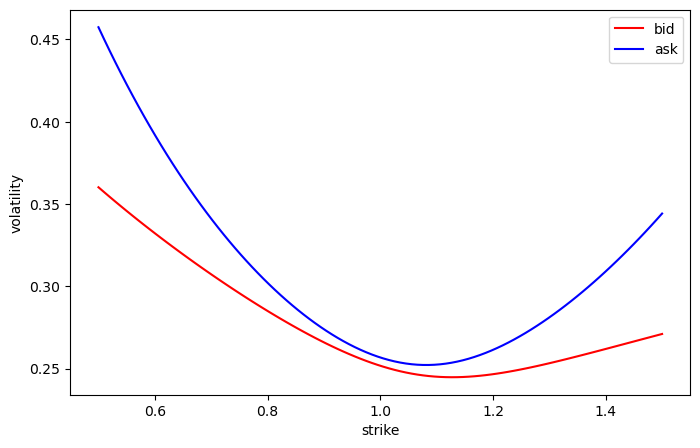

In [20]:
## Generate a bid and ask vol with a spread
spread = 1.02+np.abs(1.0-strikes)**2#((np.abs(1.0-strikes)/0.3)**3 * 0.005) + 0.005
bid_vols = input_vol
ask_vols = input_vol*spread
plt.figure(figsize=(8,5))
i = -1
plt.plot(strikes, bid_vols[i,:], 'r', label='bid')
plt.plot(strikes, ask_vols[i,:], 'b', label='ask')
plt.xlabel('strike')
plt.ylabel('volatility')
plt.legend(loc='best')
plt.show()

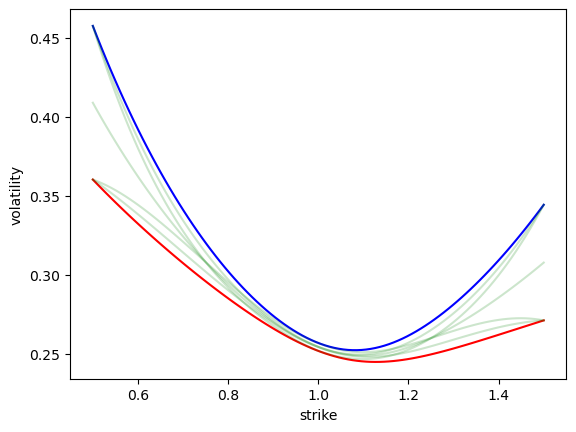

In [75]:
# generate additional volatilities
additional_vols = {}
new_vol = np.empty(bid_vols.shape)
weights = (strikes-strikes[0])/(strikes[-1]-strikes[0])
for i in range(bid_vols.shape[0]):
    new_vol[i] = weights*bid_vols[i]+(1.0-weights)*ask_vols[i]
additional_vols['enlarge_skew'] = new_vol

new_vol = np.empty(bid_vols.shape)
weights = 1.0-weights
for i in range(bid_vols.shape[0]):
    new_vol[i] = weights*bid_vols[i]+(1.0-weights)*ask_vols[i]
additional_vols['flatten skew'] = new_vol

new_vol = np.empty(bid_vols.shape)
weights = np.abs((strikes-1.0))/(1.0-strikes[0])
for i in range(bid_vols.shape[0]):
    new_vol[i] = weights*bid_vols[i]+(1.0-weights)*ask_vols[i]
additional_vols['enlarge smile'] = new_vol
    
new_vol = np.empty(bid_vols.shape)
weights = 1.0-weights
for i in range(bid_vols.shape[0]):
    new_vol[i] = weights*bid_vols[i]+(1.0-weights)*ask_vols[i]
additional_vols['flatten smile'] = new_vol

new_vol = np.empty(bid_vols.shape)
weights = 0.5
for i in range(bid_vols.shape[0]):
    new_vol[i] = weights*bid_vols[i]+(1.0-weights)*ask_vols[i]
additional_vols['mid'] = new_vol

i = -1
plt.plot(strikes, bid_vols[i,:], 'r', label='bid')
plt.plot(strikes, ask_vols[i,:], 'b', label='ask')
for k,v in additional_vols.items():
    plt.plot(strikes, v[i,:],'-g', alpha=0.2,label=k)
#plt.legend()
plt.xlabel('strike')
plt.ylabel('volatility');

In [84]:
## Calculate bid and ask prices from vols
bid_prices = np.array([[compute_european_price_Buehler(k, t, bid_vols[i,j]) 
                        for j,k in enumerate(strikes)] for  i,t in enumerate(expiries)]) #fwd=spot since r=0&d=0
ask_prices = np.array([[compute_european_price_Buehler(k, t, ask_vols[i,j]) 
                        for j,k in enumerate(strikes)] for  i,t in enumerate(expiries)])
additional_prices = {}
for k,v in additional_vols.items():
    additional_prices[k] =  np.array([[compute_european_price_Buehler(k_, t, v[i,j]) 
                        for j,k_ in enumerate(strikes)] for  i,t in enumerate(expiries)])

### Find an arbitrage-free call price surface

In [96]:
## Find arbitrage-free call price surface with linear programming
call_prices_bid = fit_arbfree_callprices(bid_prices, ask_prices, 
                                    c = np.ones((n_strikes*n_expiries)))
call_prices_ask = fit_arbfree_callprices(bid_prices, ask_prices, 
                                    c = np.ones((n_strikes*n_expiries)))
additional_prices_arbfree = {}
for k,v in additional_prices.items():
    additional_prices_arbfree[k] = fit_arbfree_callprices(v, ask_prices+0.005, c = np.ones((n_strikes*n_expiries)))

In [106]:
?compute_implied_vol_Buehler

## Calculate local volatility (from call prices directly and via implied volatilities)

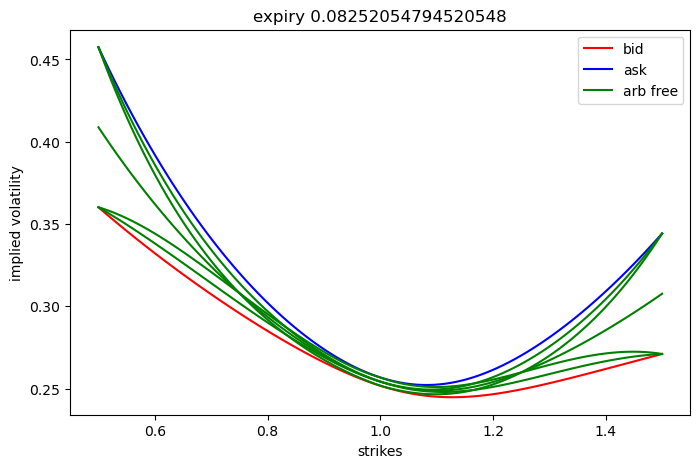

In [119]:
## Compute implied vol from call price surface
expiries_selected = [2]

additional_vols_arbfree = {}
for k,v in additional_prices_arbfree.items():
    _impl_vol = []
    for i in expiries_selected:
        tmp = []
        for j,strike in enumerate(strikes):
            #print(j, v[i,j], strike)
            try:
                if strike >= 0.0:
                    vol = compute_implied_vol_Buehler(strike, expiries[i], v[i,j], min_vol =0.01, max_vol=5.0)
                else:
                    price = v[i,j]-1.0+strike
                    vol = compute_implied_vol_Buehler(strike, expiries[i], price, min_vol = 0.01, max_vol=5.0, is_call=False)
            except:
                vol = -0.5
            tmp.append(vol)
        _impl_vol.append(tmp)
    additional_vols_arbfree[k]=_impl_vol

plt.figure(figsize=(8,5))
for i,expiry in enumerate(expiries_selected):
    #plt.plot(strikes, impl_vol[i],'o', label='expiry ' + str(expiries[expiry]))
    plt.plot(strikes, bid_vols[i,:], 'r', label='bid')
    plt.plot(strikes, ask_vols[i,:], 'b', label='ask')
    label ='arb free'
    for k,v in additional_vols_arbfree.items():
        plt.plot(strikes, v[i],'g', label = label)
        label = None
    plt.title('expiry '+ str(expiries[expiry]))
plt.legend()
plt.xlabel('strikes')
plt.ylabel('implied volatility');

In [ ]:
## Calculate local volatility from a call price surface with Dupire's equation
lv_model = LocalVol(vol_param=None, x_strikes=strikes, time_grid=expiries, call_prices=call_prices)
var = lv_model.compute_local_var(vol_param=None, call_param = call_prices, x_strikes = strikes, time_grid = expiries)
vol = np.sqrt(var)

In [42]:
expiries

array([0.00273973, 0.04263014, 0.08252055, 0.12241096, 0.16230137,
       0.20219178, 0.24208219, 0.2819726 , 0.32186301, 0.36175342,
       0.40164384, 0.44153425, 0.48142466, 0.52131507, 0.56120548,
       0.60109589, 0.6409863 , 0.68087671, 0.72076712, 0.76065753,
       0.80054795, 0.84043836, 0.88032877, 0.92021918, 0.96010959,
       1.        ])

## Monte Carlo Simulation: Calculate option prices from local vol

In [ ]:
## Monte Carlo Path Simulation to get prices from local vol
n_sims = 1_000
S = monte_carlo_path_simulation(model=lv_model, n_sims = n_sims)
S_down, check_barrier_hit_down = monte_carlo_path_simulation(model=lv_model, n_sims = n_sims, down_barrier=0.8)
S_up, check_barrier_hit_up = monte_carlo_path_simulation(model=lv_model, n_sims = n_sims, up_barrier=1.2)

## Calculate the option price from the MC paths with strike ~ spot
idx_strike = np.argwhere(strikes>spot)[0][0]  #strike close to spot, first index above current spot, ~np.argmin(np.abs(strikes-spot))
strike = strikes[idx_strike]

call_price_mc = np.mean(calc_european_vanilla_option(S, strike))

if plot:
    plt.figure(figsize=(12,4))
    call = calc_european_vanilla_option(S, strike)
    plt.hist(call, bins=50, alpha=0.5)
    plt.axvline(x=call_price_mc, color='tab:red', linewidth=2, label='mean')
    plt.show()

In [ ]:
# BARRIER OPTIONS
if True:
    #print('LP: ', (call_prices[-1,idx_strike]))
    #print('Bid:', (bid_prices[-1,idx_strike]))
    #print('Ask:', (ask_prices[-1,idx_strike]))
    #print('Ref:', compute_european_price_Buehler(strike=strike, maturity=expiries[-1], volatility=input_vol[-1,idx_strike])) #reference solution for call close to expiry
    print('Monte Carlo Simulation:')
    print('Call: ', call_price_mc)
    print('Put: ', np.mean(calc_european_vanilla_option(S, strike, type='put'))) 
    print('DownAndOutPut: ', np.mean(calc_barrier_option(S_down, strike, check_barrier_hit_down))) 
    print('DownAndInPut: ', np.mean(calc_barrier_option(S_down, strike, check_barrier_hit_down, option_type='down_and_in_put'))) 
    print('UpAndOutPut: ', np.mean(calc_barrier_option(S_up, strike, check_barrier_hit_up, option_type='up_and_out_put'))) 
    print('UpAndInPut: ', np.mean(calc_barrier_option(S_up, strike, check_barrier_hit_up, option_type='up_and_in_put'))) 
    print('DownAndOutCall: ', np.mean(calc_barrier_option(S_down, strike, check_barrier_hit_down, option_type='down_and_out_call'))) 
    print('DownAndInCall: ', np.mean(calc_barrier_option(S_down, strike, check_barrier_hit_down, option_type='down_and_in_call'))) 
    print('UpAndOutCall: ', np.mean(calc_barrier_option(S_up, strike, check_barrier_hit_up, option_type='up_and_out_call'))) 
    print('UpAndInCall: ', np.mean(calc_barrier_option(S_up, strike, check_barrier_hit_up, option_type='up_and_in_call'))) 

## Convex combination of volatilities (interpolated)

In [ ]:
mu1 = np.linspace(0, 1, num=n_strikes)
vol_mu1_ab = mu1*bid_vols + (1-mu1)*ask_vols #ask -> bid
vol_mu1_ba = (1-mu1)*bid_vols + (mu1)*ask_vols #bid -> ask

nb = int(n_strikes/2)
eps = 1E-3
mu2_x = np.linspace(min(strikes),max(strikes),2*nb)
mu2_y = np.append(np.linspace(eps,1-eps, num=nb), np.linspace(1-eps,eps, num=nb))
mu2 = interpolate.interp1d(mu2_x, mu2_y, kind='quadratic')(strikes)
vol_mu2_aba = mu2*bid_vols + (1-mu2)*ask_vols #ask -> bid -> ask
vol_mu2_bab = (1-mu2)*bid_vols + (mu2)*ask_vols #bid -> ask -> bid

if plot:
    i = 3  #i in len(expiries)
    plt.figure(figsize=(8,5))
    plt.plot(strikes, bid_vols[i,:], 'ro')
    plt.plot(strikes, ask_vols[i,:], 'bx')
    plt.plot(strikes, vol_mu1_ab[i,:], 'k-')
    plt.plot(strikes, vol_mu1_ba[i,:], 'k--')
    plt.plot(strikes, vol_mu2_aba[i,:], 'g-')
    plt.plot(strikes, vol_mu2_bab[i,:], 'g--')
    plt.xlabel('strikes')
    plt.ylabel('volatilities')
    plt.show()

In [ ]:
mu1_ab_prices = np.array([[compute_european_price_Buehler(k, t, vol_mu1_ab[i,j]) 
                           for j,k in enumerate(strikes)] for  i,t in enumerate(expiries)])

mu1_ba_prices = np.array([[compute_european_price_Buehler(k, t, vol_mu1_ba[i,j]) 
                           for j,k in enumerate(strikes)] for  i,t in enumerate(expiries)])

mu2_aba_prices = np.array([[compute_european_price_Buehler(k, t, vol_mu2_aba[i,j]) 
                           for j,k in enumerate(strikes)] for  i,t in enumerate(expiries)])

mu2_bab_prices = np.array([[compute_european_price_Buehler(k, t, vol_mu2_bab[i,j]) 
                           for j,k in enumerate(strikes)] for  i,t in enumerate(expiries)])

if plot:
    i = 3
    plt.figure(figsize=(8,5))
    plt.plot(bid_prices[i,:], 'ro')
    plt.plot(ask_prices[i,:], 'bx')
    plt.plot(mu1_ab_prices[i,:], 'k-')
    plt.plot(mu1_ba_prices[i,:], 'k--')
    plt.plot(mu2_aba_prices[i,:], 'g-')
    plt.plot(mu2_bab_prices[i,:], 'g--')
    plt.xlabel('strikes')
    plt.ylabel('prices')
    plt.show()

In [ ]:
# find closest arbitrage free price
call_prices_mu1_ab = linear_program_call_prices_with_lower_bound(mu1_ab_prices, c = np.ones((n_strikes*n_expiries)))
call_prices_mu1_ba = linear_program_call_prices_with_lower_bound(mu1_ba_prices, c = np.ones((n_strikes*n_expiries)))
call_prices_mu2_aba = linear_program_call_prices_with_lower_bound(mu2_aba_prices, c = np.ones((n_strikes*n_expiries)))
call_prices_mu2_bab = linear_program_call_prices_with_lower_bound(mu2_bab_prices, c = np.ones((n_strikes*n_expiries)))
#call_prices_mu2_bab = linear_program_call_prices_with_upper_bound(mu2_bab_prices, c = -1*np.ones((n_strikes*n_expiries)))

call_prices_b = linear_program_call_prices_with_spread(bid_prices, ask_prices, c = np.ones((n_strikes*n_expiries)))
call_prices_a = linear_program_call_prices_with_spread(bid_prices, ask_prices, c = -1*np.ones((n_strikes*n_expiries)))

if plot: # plot call prices for different strikes at a specified expiry
    plt.figure(figsize=(8,5))
    i = 3 #i in range(len(expiries))
    plt.plot(strikes, call_prices_b[i,:], 'rx') #close to bid
    plt.plot(strikes, call_prices_a[i,:], 'bo', markersize=4) #close to ask
    plt.plot(strikes, call_prices_mu1_ab[i,:],  linewidth=2)
    plt.plot(strikes, call_prices_mu1_ba[i,:], linewidth=2) 
    plt.plot(strikes, call_prices_mu2_aba[i,:], linewidth=2)
    plt.plot(strikes, call_prices_mu2_bab[i,:], linewidth=2)
    plt.xlabel('strikes')
    plt.ylabel('price')
    plt.tight_layout()
    plt.show()

In [ ]:
# implied vol from call prices
impl_vol_a = compute_implied_vol_from_call(expiries, strikes, call_prices_b)
impl_vol_b = compute_implied_vol_from_call(expiries, strikes, call_prices_a)
impl_vol_ab = compute_implied_vol_from_call(expiries, strikes, call_prices_mu1_ab)
impl_vol_ba = compute_implied_vol_from_call(expiries, strikes, call_prices_mu1_ba)
impl_vol_aba = compute_implied_vol_from_call(expiries, strikes, call_prices_mu2_aba)
impl_vol_bab = compute_implied_vol_from_call(expiries, strikes, call_prices_mu2_bab)

if plot:
    plt.figure(figsize=(12,6))
    i = 3    #for i in range(2,len(expiries)):
    plt.plot(strikes, impl_vol_a[i,:], 'rx', label='bid') #close to bid
    plt.plot(strikes, impl_vol_b[i,:], 'bo', markersize=4, label='ask') #close to ask
    plt.plot(strikes, impl_vol_ab[i,:], '--', color='tab:orange', linewidth=2, label='ask->bid')
    plt.plot(strikes, impl_vol_ba[i,:], '.-', color='tab:purple', linewidth=2, label='bid->ask')
    plt.plot(strikes, impl_vol_aba[i,:], 'gx-', linewidth=2, label='ask->bid->ask')
    plt.plot(strikes, impl_vol_bab[i,:], '.', color='tab:cyan', linewidth=2, label='bid->ask->bid')
    plt.legend(loc='best')
    plt.xlabel('strikes')
    plt.ylabel('implied volatility')
    plt.show()

In [ ]:
n_sims = 10_000

## Calculate the option price from the MC paths with strike ~ spot
idx_strike = np.argwhere(strikes>1.2)[0][0]  #np.argwhere(strikes>spot)[0][0]  #strike close to spot, first index above current spot, ~np.argmin(np.abs(strikes-spot))
strike = strikes[idx_strike]

def calc_option_price_at_spot_with_local_vol(call_price, strikes, expiries, n_sims, at_strike):    
    lv_model = LocalVol(vol_param=None, x_strikes=strikes, time_grid=expiries, call_prices=call_price)
    vol = np.sqrt(lv_model.compute_local_var(vol_param=None, call_param = call_price, x_strikes = strikes, time_grid = expiries))
    S = monte_carlo_path_simulation(model=lv_model, n_sims = n_sims)
    call_price = np.mean(calc_european_vanilla_option(S, at_strike))
    return vol, call_price

vol1, call_price1 = calc_option_price_at_spot_with_local_vol(call_prices_b, strikes, expiries, n_sims, strike)
vol2, call_price2 = calc_option_price_at_spot_with_local_vol(call_prices_a, strikes, expiries, n_sims, strike)
vol3, call_price3 = calc_option_price_at_spot_with_local_vol(call_prices_mu1_ab, strikes, expiries, n_sims, strike)
vol4, call_price4 = calc_option_price_at_spot_with_local_vol(call_prices_mu1_ba, strikes, expiries, n_sims, strike)
vol5, call_price5 = calc_option_price_at_spot_with_local_vol(call_prices_mu2_aba, strikes, expiries, n_sims, strike)
vol6, call_price6 = calc_option_price_at_spot_with_local_vol(call_prices_mu2_bab, strikes, expiries, n_sims, strike)

if plot:
    i = 3    #for i in range(1,len(expiries)):
    plt.figure(figsize=(12,6))
    plt.plot(strikes, vol1[i,:], 'rx', label='bid') #close to bid
    plt.plot(strikes, vol2[i,:], 'bo', markersize=4, label='ask') #close to ask
    plt.plot(strikes, vol3[i,:], '--', color='tab:orange', linewidth=2, label='ask->bid')
    plt.plot(strikes, vol4[i,:], '.-', color='tab:purple', linewidth=2, label='bid->ask')
    plt.plot(strikes, vol5[i,:], 'gx-', linewidth=2, label='ask->bid->ask')
    plt.plot(strikes, vol6[i,:], '.', color='tab:cyan', linewidth=2, label='bid->ask->bid')
    plt.xlabel('strikes')
    plt.ylabel('local volatility')
    plt.legend(loc='best')
    plt.show()

### Many convex combinations of local vols

In [ ]:
def monte_carlo_down_and_out_put(vol: np.ndarray, strike: float, barrier: float, n_sims: int = 100_000, n_time_steps: int = 365, seed = None):

    if seed is not None:
        np.random.seed(seed)    
        
    lv_model = LocalVol(vol_param=None, x_strikes=strikes, time_grid=expiries, call_prices=None, local_vol_grid=vol)
    S = np.ones((n_sims,1))
    time_grid_mc = np.linspace(0.0, 1.0, n_time_steps)
    check_barrier_hit = np.ones(n_sims) #False
    
    for i in range(1,time_grid_mc.shape[0]):
        rnd = np.random.normal(size=(n_sims, 1))
        lv_model.apply_mc_step(S, time_grid_mc[i-1], time_grid_mc[i], rnd, inplace=True)
        
        for j in range(len(check_barrier_hit)):
            if S[j,:] <= barrier:
                check_barrier_hit[j] = 0 #True / was hit
                    
    return np.multiply(np.maximum(strike-S, 0)[:,0], check_barrier_hit)

In [ ]:
## Compute the down and out put price for a convex combination of all six local vols

n_sims = 1_000_000 #1_000
nb_param = 1 #100

np.random.seed(0)
chi_param = np.random.uniform(size=(6,nb_param))
chi_uncertain = chi_param/np.sum(chi_param, axis=0)

vol_uncertain = np.zeros((nb_param, n_expiries, n_strikes))
uq_down_and_out_put_price_mean = np.zeros(nb_param)
uq_down_and_out_put_price_std = np.zeros(nb_param)
uq_down_and_out_put_payoff = np.zeros((nb_param, n_sims))

for j in range(nb_param):
    vol_uncertain[j,:,:] = chi_uncertain[0,j]*vol1 + chi_uncertain[1,j]*vol2 + chi_uncertain[2,j]*vol3 + \
                    chi_uncertain[3,j]*vol4 + chi_uncertain[4,j]*vol5 + chi_uncertain[5,j]*vol6 #should be arbitrage-free

    uq_down_and_out_put_payoff[j,:] = monte_carlo_down_and_out_put(vol_uncertain[j,:,:], strike=strike, barrier=0.7, n_sims=n_sims, n_time_steps=366, seed=0)
    uq_down_and_out_put_price_mean[j] = np.mean(uq_down_and_out_put_payoff[j,:])
    uq_down_and_out_put_price_std[j] = np.std(uq_down_and_out_put_payoff[j,:])

print('Mean:', uq_down_and_out_put_price_mean, '\nStd: ', uq_down_and_out_put_price_std)

if not plot:
    plt.figure(figsize=(8,3))
    plt.hist(uq_down_and_out_put_price_mean, bins=50, alpha=0.5)
    plt.xlabel('down and out put price')
    plt.show()

    plt.figure(figsize=(8,3))
    plt.hist(uq_down_and_out_put_price_std, bins=50, alpha=0.4)
    plt.xlabel('standard deviation (down and out put price)')
    plt.show()

if False: #export csv
    import pandas as pd
    df_chi = pd.DataFrame(chi_uncertain.T)
    df_chi.to_csv('uncertainty_data_chi_.csv')

    df_prices = pd.DataFrame(uq_down_and_out_put_payoff.T)
    df_prices.to_csv('uncertainty_data_prices_.csv')

    df_mean_std = pd.DataFrame({'mean': uq_down_and_out_put_price_mean, 'std': uq_down_and_out_put_price_std})
    df_mean_std.to_csv('uncertainty_data_mean_std_.csv')

## TODO: Multilevel Monte Carlo Method

In [ ]:
import bisect
def interpolate_2D(time_grid, strikes, f, x, t):
    t_index = bisect.bisect_left(time_grid, t)
    if t_index == 0:# or t0_index == self._time_grid.shape[0]:
        result = f[0]
    elif t_index == time_grid.shape[0]-1:
        result = f[-1]
    else:
        dt = time_grid[t_index] - time_grid[t_index-1]
        w1 = (t-time_grid[t_index-1])/dt
        w2 = (time_grid[t_index] - t)/dt
        result = w1*f[t_index] + w2*f[t_index-1]
    return np.interp(x, strikes, result)

def monte_carlo_down_and_out_put_mlmc(vol: np.ndarray, x_strikes: np.ndarray, expiries: np.ndarray, strike: float, barrier: float, n_sims: int = 100_000, n_time_steps: int = 365, seed = None):

    if seed is not None:
        np.random.seed(seed)    
        
    lv_model = LocalVol(vol_param=None, x_strikes=x_strikes, time_grid=expiries, call_param=None, local_vol_grid=vol)
    S = np.ones((n_sims,1))
    time_grid_mc = np.linspace(0.0, 1.0, n_time_steps)
    check_barrier_hit = np.ones(n_sims) #False
    
    for i in range(1,time_grid_mc.shape[0]):
        rnd = np.random.normal(size=(n_sims, 1))
        
        ### S = lv_model.apply_mc_step(lv_model, S, time_grid_mc, rnd)
        dt = time_grid_mc[i] - time_grid_mc[i-1]
        sqrt_dt = np.sqrt(dt)
        path = S[:,0]
        lv = interpolate_2D(time_grid_mc, x_strikes, lv_model._local_variance, path, time_grid_mc[i-1])
        path *= np.exp(- 0.5*lv*dt + np.sqrt(lv)*rnd[:,0]*sqrt_dt)

        for j in range(len(check_barrier_hit)):
            if S[j,:] <= barrier:
                check_barrier_hit[j] = 0 #True / was hit
                    
    return np.multiply(np.maximum(strike-S, 0)[:,0], check_barrier_hit)
       

In [ ]:
def multilevel_monte_carlo_down_and_out_put(vol: np.ndarray, strike: float, barrier: float, seed = None):
    ### The quantity P_i^l − P_i^l−1 comes from two discrete approximations with different timesteps but the same Brownian path
    ### This is easily implemented by first constructing the Brownian increments for the simulation of the discrete path leading to the evaluation of P_i^l,
    ### and then summing them in groups of size M to give the discrete Brownian increments for the evaluation of P_i^l−1

    if seed is not None:
        np.random.seed(seed)    

    #nb_levels = 5
    #nb_samples = [100_000, 50_000, 10_000, 5_000, 1_000]
    #n_time_steps = [10, 50, 100, 200, 365] 
    M = 4 #M integer, M ~ 4-8 (7)
    T = 365
    eps = 1E-8    
    conv = 1 
    max_lvl = 0 #current level L=0
    V = [] #variance of simulation 
    #C = [] #cost, C = N_0 + sum_l=0...L N_l*(M^l + M^(l+1)), proportional to sum N_l/h_l, total nb of timesteps, 
    h = [] #time_step, h_l = M^⁻l * T for integer M>=2
    all_samples = []
    nb_all_samples = []
    init_samples = 1E4

    #!!! the samples have to be from the same Brownian path

    while conv > 1/np.sqrt(2) * (M**2 - 1) * eps:

        #estimate V_L with N_L=10^4 samples at level L
        h_L = M**(-max_lvl)*T 
        samples_at_lvl = monte_carlo_down_and_out_put_mlmc(vol, strike, barrier, init_samples, h_L)
        V_lvl = np.var(samples_at_lvl)
        V = np.append(V, V_lvl)

        #define optimal number of samples N_l on all levels l=0...L
        for lvl in range(max_lvl):
            h_lvl = M**(-lvl)*T #n_time_steps[lvl] #set number of time steps
            h = np.append(h, h_lvl)
            nb_samples_lvl = np.ceil(2/(eps**2) * np.sqrt(V_lvl*h_lvl) * np.sum(np.sqrt(V/h)))
            nb_all_samples = np.append(nb_all_samples, int(nb_samples_lvl))

            #evaluate additional samples on each level l=0...L according to N_l
            additional_samples_at_lvl = monte_carlo_down_and_out_put_mlmc(vol, strike, barrier, nb_samples_lvl-init_samples, h_lvl)

            all_samples.append(np.append(samples_at_lvl, additional_samples_at_lvl))
            
        if max_lvl >= 2:
            #test for convergence
            Y_max_lvl = 1/nb_all_samples[-1] * np.sum(all_samples[max_lvl].mean() - all_samples[max_lvl-1].mean())
            Y__maxlvl_1 = 1/nb_all_samples[-2] * np.sum(all_samples[max_lvl-1].mean() - all_samples[max_lvl-2].mean())
            conv = np.abs(Y_max_lvl - 1/M *Y__maxlvl_1)
        
        max_lvl += 1
               
    return 0

    '''while conv > 1/np.sqrt(2) * (M**2 - 1) * eps:

        #evaluate model at samples on all levels l = 0...L
        for lvl in range(max_lvl):

            #set number of time steps
            h_lvl = M**(-lvl)*T #n_time_steps[lvl]
            h = np.append(h, h_lvl)

            #estimate V_L with N_L=10^4 samples at level L
            samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, init_samples, h_lvl)
            #samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, nb_samples[lvl], n_time_steps[lvl])
            
            #compute sample variance on all levels
            V_lvl = np.var(samples_at_lvl)
            V = np.append(V, V_lvl)

            #define optimal number of samples on all levels l=0...L
            nb_samples_lvl = np.ceil(2/(eps**2) * np.sqrt(V_lvl*h_lvl) * np.sum(np.sqrt(V/h)))
            nb_all_samples = np.append(nb_all_samples, int(nb_samples_lvl))

            #C_lvl = 1 #TODO
            #C = np.append(C, C_lvl)

            nb_samples_lvl = 50 #int(1/(eps**2) * np.sqrt(V[lvl]/C[lvl]) * np.sum(np.sqrt(V*C)))
            nb_all_samples = np.append(nb_all_samples, int(nb_samples_lvl))

            #evaluate additional samples on each level l=0...L according to N_l
            additional_samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, nb_samples_lvl-init_samples, h_lvl)
            #additional_samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, nb_samples_lvl, n_time_steps[lvl])

            all_samples.append(np.append(samples_at_lvl, additional_samples_at_lvl))
            
        if max_lvl >= 2:
            #test for convergence
            Y_max_lvl = 1/nb_all_samples[-1] * np.sum(all_samples[max_lvl].mean() - all_samples[max_lvl-1].mean())
            Y__maxlvl_1 = 1/nb_all_samples[-2] * np.sum(all_samples[max_lvl-1].mean() - all_samples[max_lvl-2].mean())
            conv = np.abs(Y_max_lvl - 1/M *Y__maxlvl_1)   

        max_lvl += 1
        
    ##calculate the multilevel_estimator 
    #multilevel_estimator = 1/nb_all_samples[0] * np.sum(all_samples[0].mean()) 
    #for lvl in range(1,max_lvl):
    #    print(lvl, all_samples[lvl].shape, all_samples[lvl-1].shape)
    #    multilevel_estimator += 1/nb_all_samples[lvl] * np.sum(all_samples[lvl].mean() - all_samples[lvl-1].mean())
    #    
    #return multilevel_estimator
    '''

In [ ]:
#OLD?

def multilevel_monte_carlo_down_and_out_put(vol: np.ndarray, strike: float, barrier: float, seed = None):

    if seed is not None:
        np.random.seed(seed)    

    #nb_levels = 5
    #nb_samples = [100_000, 50_000, 10_000, 5_000, 1_000]
    #n_time_steps = [10, 50, 100, 200, 365] 
    M = 4 #M integer, M ~ 4-8 (7)
    T = 365
    eps = 1E-8    
    conv = 1 
    max_lvl = 0 #current level L=0
    V = [] #variance of simulation 
    #C = [] #cost, C = N_0 + sum_l=0...L N_l*(M^l + M^(l+1)), proportional to sum N_l/h_l, total nb of timesteps, 
    h = [] #n_time_steps
    all_samples = []
    nb_all_samples = []
    init_samples = 1E4

    #the samples have to be from the same Brownian path

    while conv > 1/np.sqrt(2) * (M**2 - 1) * eps:

        #evaluate model at samples on all levels l = 0...L
        for lvl in range(max_lvl):

            #set number of time steps
            h_lvl = M**(-lvl)*T #n_time_steps[lvl]
            h = np.append(h, h_lvl)

            #estimate V_L with N_L=10^4 samples at level L
            samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, init_samples, h_lvl)
            V_lvl = np.var(samples_at_lvl)
            V = np.append(V, V_lvl)

            #define optimal number of samples on all levels l=0...L
            nb_samples_lvl = np.ceil(2/(eps**2) * np.sqrt(V_lvl*h_lvl) * np.sum(np.sqrt(V/h)))
            nb_all_samples = np.append(nb_all_samples, int(nb_samples_lvl))

            #evaluate additional samples on each level l=0...L according to N_l
            additional_samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, nb_samples_lvl-init_samples, h_lvl)

            all_samples.append(np.append(samples_at_lvl, additional_samples_at_lvl))
            
        if max_lvl >= 2:
            #test for convergence
            Y_max_lvl = 1/nb_all_samples[-1] * np.sum(all_samples[max_lvl].mean() - all_samples[max_lvl-1].mean())
            Y__maxlvl_1 = 1/nb_all_samples[-2] * np.sum(all_samples[max_lvl-1].mean() - all_samples[max_lvl-2].mean())
            conv = np.abs(Y_max_lvl - 1/M *Y__maxlvl_1)
        
        max_lvl += 1
               
    return 0

    '''while conv > 1E-8:

        #evaluate model at samples on all levels l = 0...L
        for lvl in range(max_lvl):
            samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, nb_samples[lvl], n_time_steps[lvl])
            
            #compute sample variance on all levels
            V_lvl = np.var(samples_at_lvl)
            V = np.append(V, V_lvl)

            #determine optimal number of samples on all levels
            C_lvl = 1 #TODO
            C = np.append(C, C_lvl)

            nb_samples_lvl = 50 #int(1/(eps**2) * np.sqrt(V[lvl]/C[lvl]) * np.sum(np.sqrt(V*C)))
            nb_all_samples = np.append(nb_all_samples, int(nb_samples_lvl))

            #take additional samples on each level l=0...L according to N_l
            additional_samples_at_lvl = monte_carlo_down_and_out_put(vol, strike, barrier, nb_samples_lvl, n_time_steps[lvl])

            all_samples.append(np.append(samples_at_lvl, additional_samples_at_lvl))
            
        if max_lvl >= 2:
            #test for convergence
            conv = 0 #TODO
        
        max_lvl += 1
        
    #calculate the multilevel_estimator 
    multilevel_estimator = 1/nb_all_samples[0] * np.sum(all_samples[0].mean()) 
    for lvl in range(1,max_lvl):
        print(lvl, all_samples[lvl].shape, all_samples[lvl-1].shape)
        multilevel_estimator += 1/nb_all_samples[lvl] * np.sum(all_samples[lvl].mean() - all_samples[lvl-1].mean())
        
    return multilevel_estimator
    '''

In [ ]:
## Compute the down and out put price for a convex combination of all six local vols

n_sims = 100

nb_param = 1
np.random.seed(0)
chi_param = np.random.uniform(size=(6,nb_param))
chi_uncertain = chi_param/np.sum(chi_param, axis=0)

vol_uncertain = np.zeros((nb_param, n_expiries, n_strikes))
uq_down_and_out_put_price_mean = np.zeros(nb_param)
uq_down_and_out_put_price_std = np.zeros(nb_param)
uq_down_and_out_put_payoff = np.zeros((nb_param, n_sims))

for j in range(nb_param):
    vol_uncertain[j,:,:] = chi_uncertain[0,j]*vol1 + chi_uncertain[1,j]*vol2 + chi_uncertain[2,j]*vol3 + \
                    chi_uncertain[3,j]*vol4 + chi_uncertain[4,j]*vol5 + chi_uncertain[5,j]*vol6 #should be arbitrage-free

    uq_down_and_out_put_payoff[j,:] = multilevel_monte_carlo_down_and_out_put(vol_uncertain[j,:,:], strike=strike, barrier=0.7, seed=0)
    uq_down_and_out_put_price_mean[j] = np.mean(uq_down_and_out_put_payoff[j,:])
    uq_down_and_out_put_price_std[j] = np.std(uq_down_and_out_put_payoff[j,:])

print('Mean:', uq_down_and_out_put_price_mean, '\nStd: ', uq_down_and_out_put_price_std)

### Additional stuff

In [ ]:
## Compute local vol for a convex combination of all six local vols
## and the call price from the new local vol with MC

nb_param = 100
np.random.seed(42)
chi_param = np.random.uniform(size=(6,nb_param))
chi_uncertain = chi_param/np.sum(chi_param, axis=0)
vol_uncertain = np.zeros((nb_param, n_expiries, n_strikes))
uq_call_payoff = np.zeros((nb_param, n_sims, 1))
uq_call_price_mean = np.zeros(nb_param)
uq_call_price_std = np.zeros(nb_param)
impl_vol_call_uncertain = np.zeros(nb_param)

for j in range(nb_param):
    vol_uncertain[j,:,:] = chi_uncertain[0,j]*vol1 + chi_uncertain[1,j]*vol2 + chi_uncertain[2,j]*vol3 + \
                    chi_uncertain[3,j]*vol4 + chi_uncertain[4,j]*vol5 + chi_uncertain[5,j]*vol6 #should be arbitrage-free
    lv_uncertain = LocalVol(vol_param=None, x_strikes=strikes, time_grid=expiries, call_param=None, local_vol_grid=vol_uncertain[j,:,:])
    S = monte_carlo_path_simulation(model=lv_uncertain, n_sims = n_sims)
    uq_call_payoff[j,:,:] = calc_european_vanilla_option(S, strike)
    uq_call_price_mean[j] = np.mean(uq_call_payoff[j])
    uq_call_price_std[j] = np.std(uq_call_payoff[j])
    impl_vol_call_uncertain[j] = compute_implied_vol_Buehler(strike, expiries[-1], uq_call_price_mean[j])    # implied vol for a specific strike and expiry
    #plt.hist(S, bins=100) # distribution of "final" prices on the MC paths

if plot:
    plt.figure(figsize=(12,6))
    i = 5
    for j in range(nb_param): 
        # for _ in range(3): j = np.random.randint(nb_param)
        plt.plot(strikes, vol_uncertain[j,i,:], 'k', alpha=0.5)
    plt.plot(strikes, vol1[i,:], 'rx', alpha=0.3)
    plt.plot(strikes, vol2[i,:], 'bo', alpha=0.3)
    plt.plot(strikes, vol3[i,:], '--', color='tab:orange', alpha=0.3)
    plt.plot(strikes, vol4[i,:], '.-', color='tab:purple', alpha=0.3)
    plt.plot(strikes, vol5[i,:], 'gx-', alpha=0.3)
    plt.plot(strikes, vol6[i,:], '.', color='tab:cyan', alpha=0.3)
    plt.xlabel('strike')
    plt.ylabel('local volatility')
    plt.tight_layout()
    plt.show()

    # histograms
    plt.figure(figsize=(8,3))
    plt.hist(uq_call_price_mean, bins=50, color='black', alpha=0.5)
    plt.axvline(x=call_price1, color='red', linewidth=2, label='bid')
    plt.axvline(x=call_price2, color='blue', linewidth=2, label='ask')
    plt.axvline(x=call_price3, color='tab:orange', linewidth=2, label='ask->bid')
    plt.axvline(x=call_price4, color='tab:purple', linewidth=2, label='bid->ask')
    plt.axvline(x=call_price5, color='green', linewidth=2, label='ask->bid->ask')
    plt.axvline(x=call_price6, color='tab:cyan', linewidth=2, label='bid->ask->bid')
    plt.xlabel('mean (call price)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,3))
    plt.hist(uq_call_price_std, bins=50, alpha=0.4)
    plt.xlabel('standard deviation (call price)')
    plt.show()

    plt.figure(figsize=(8,3))
    plt.hist(impl_vol_call_uncertain, bins=50, alpha=0.5)
    plt.xlabel('implied volatility (call price)')
    plt.show()

if False:
    import pandas as pd
    out_dict = {'chi1': chi_uncertain[0,:],
                'chi2': chi_uncertain[1,:],
                'chi3': chi_uncertain[2,:],
                'chi4': chi_uncertain[3,:],
                'chi5': chi_uncertain[4,:],
                'chi6': chi_uncertain[5,:],
                'uq_call_price_mean': uq_call_price_mean, 
                'uq_call_price__std': uq_call_price_std, 
                }
    df = pd.DataFrame(out_dict)
    df.to_csv('uncertainty_data_call.csv')

In [ ]:
## DIFFERENT APPROACH: Linear program and convex combination for different volatilites

# Check convex combination of vols
call_prices1 = linear_program_call_prices_with_spread(bid_prices, ask_prices, c = np.ones((n_strikes*n_expiries)))
vol1, call_price1 = calc_option_price_at_spot_with_local_vol(call_prices1, strikes, expiries, n_sims, strike) #bid/low
#print('Call Bid MC: ', call_price1, '\nCall Bid LP: ', call_prices1[-1,idx_strike])

call_prices2 = linear_program_call_prices_with_spread(bid_prices, ask_prices, c = -1*np.ones((n_strikes*n_expiries)))
vol2, call_price2 = calc_option_price_at_spot_with_local_vol(call_prices2, strikes, expiries, n_sims, strike) #ask/high

c3 = np.ones((n_expiries,n_strikes))
c3[:,:idx_strike] = -1.0
c3 = c3.flatten()
call_prices3 = linear_program_call_prices_with_spread(bid_prices, ask_prices, c = c3)
vol3, call_price3 = calc_option_price_at_spot_with_local_vol(call_prices3, strikes, expiries, n_sims, strike)

c4 = np.ones((n_expiries,n_strikes))
c4[:,idx_strike:] = -1.0
c4 = c4.flatten()
call_prices4 = linear_program_call_prices_with_spread(bid_prices, ask_prices, c = c4)
vol4, call_price4 = calc_option_price_at_spot_with_local_vol(call_prices4, strikes, expiries, n_sims, strike)

## Compute implied vol for a convex combination of 2 call prices at all strikes
nb_param = 10
chi_param = np.random.uniform(size=nb_param)
#vol_uncertain = (chi_uncertain[j]*vol1 + (1-chi_uncertain[j])*vol2)
call_uncertain = np.outer(chi_param,call_prices1[-1,:]) + np.outer((1-chi_param),call_prices2[-1,:])
impl_vol_uncertain = np.array([[compute_implied_vol_Buehler(k, expiries[-1], call_uncertain[i,j]) for j,k in enumerate(strikes)] for i in range(nb_param)])

if plot:
    #plot call prices and implied vol for specified expiry
    plt.figure(figsize=(8,5))
    for i in range(nb_param):
        plt.plot(strikes, call_uncertain[i,:], alpha=0.5)
    plt.plot(strikes, call_prices1[-1,:], 'bx')
    plt.plot(strikes, call_prices2[-1,:], 'ro')
    #plt.plot(strikes, bid_prices[-1,:], 'bx', label='bid') 
    #plt.plot(strikes, ask_prices[-1,:], 'ro', label='ask')
    plt.xlabel('strike')
    plt.ylabel('price')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    for i in range(nb_param):
        plt.plot(strikes, impl_vol_uncertain[i,:], alpha=0.5)
    plt.plot(strikes, bid_vols[-1,:], 'bx', label='bid')
    plt.plot(strikes, ask_vols[-1,:], 'ro', label='call')
    plt.xlabel('strike')
    plt.ylabel('implied volatility')
    #plt.legend()
    plt.tight_layout()
    plt.show()  